In [8]:
from utils import get_path, load_data

INDEX_DIR = '../../index'

TRAIN, TEST = load_data(
    index_dir=INDEX_DIR,
    index_name='mimic3-mimic3',
    reference_name='mimic3-mimic3_reference.csv',
    mapper={
        'train': {'mimic3_A': 'mimic3_train_A', 'mimic3_B': 'mimic3_train_B'},
        'test': {'mimic3_A': 'mimic3_test_A', 'mimic3_B': 'mimic3_test_B'},
    }
)

In [6]:
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline

from dmatch.utils import NamedFeatureSelector

from utils import Model

input_features = TRAIN.drop('Y', axis=1).columns.to_list()

features = [
    'mean',
    'std',
    'var',
    'frequency',
    'hellinger_distance',
    'ks_test',
    'scaled_hellinger_distance',
    'scaled_ks_test',
]

f1 = [
    'mean',
    'hellinger_distance',
    'ks_test',
]
f3 = [
    'mean',
    'hellinger_distance',
    'ks_test',
    'scaled_hellinger_distance',
    'scaled_ks_test',
]

models = {
    'tree':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('tree', DecisionTreeClassifier())
            ]),
            {
                'filter__selected_columns': [f1],
                'tree__max_depth': [2], #range(2, 5),
                'tree__criterion': ['gini'], #['gini', 'entropy'],
                'tree__class_weight': [None], #['balanced',  None],
                'tree__min_samples_leaf': [30]
            }
        ),
    'forest':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('forest', RandomForestClassifier())
            ]),
            {
                'filter__selected_columns': [f3],
                'forest__n_estimators': [250], #range(100, 401, 50),
                'forest__criterion': ['entropy'], #['gini', 'entropy'],
                'forest__class_weight': ['balanced'], #['balanced', None],
                'forest__max_depth': [None],
                'forest__min_samples_leaf': [1]
            }
        ),
    'logistic':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, features)),
                ('logit', LogisticRegression())
            ]),
            {
                'filter__selected_columns': [f1],
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'kolmogorov-smirnov':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['ks_test'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'hellinger':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['hellinger_distance'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': [None],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'mean':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['mean'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced'],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
    'std':
        Model(
            Pipeline([
                ('filter', NamedFeatureSelector(input_features, ['std'])),
                ('logit', LogisticRegression())
            ]),
            {
                'logit__class_weight': ['balanced'],
                'logit__C': [1e2],
                'logit__tol': [1e-5],
                'logit__max_iter': [10000],
            }
        ),
}

for key, model in models.items():
    print(f"{'='*5} {key} {'='*5}")
    model.train(TRAIN)
    print(model.best_params)
    model.test(TEST, rep=1000)
    model.print_scores()
    print()

===== tree =====
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'filter__selected_columns': ['mean', 'hellinger_distance', 'ks_test'], 'tree__class_weight': None, 'tree__criterion': 'gini', 'tree__max_depth': 2, 'tree__min_samples_leaf': 30}
f1 : mean: 0.89, std: 0.02, 0.95 confidence interval: [0.87, 0.92]
precision : mean: 0.87, std: 0.03, 0.95 confidence interval: [0.83, 0.92]
recall : mean: 0.91, std: 0.02, 0.95 confidence interval: [0.88, 0.94]
average_precision_score : 0.8576851974313259
tm_score_A_to_B : 0.9895287958115183
tm_score_B_to_A : 0.9895287958115183

===== forest =====
Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'filter__selected_columns': ['mean', 'hellinger_distance', 'ks_test', 'scaled_hellinger_distance', 'scaled_ks_test'], 'forest__class_weight': 'balanced', 'forest__criterion': 'entropy', 'forest__max_depth': None, 'forest__min_samples_leaf': 1, 'forest__n_estimators': 250}
f1 : mean: 0.89, std: 0.01, 0.95 confidence interval: [0.88, 

In [12]:
from dmatch.utils import Score
import pandas as pd

df = TEST.copy()
df['y_proba'] = models['tree'].best_model.predict_proba(df.drop('Y', axis=1))[:,1]
tm_rank = df.groupby('entityA').apply(Score.tm_rank, ret=5)

x = df.reset_index().entityA.apply(lambda x: tm_rank[x])
x = x.rename('mapping')

d = pd.concat([df.reset_index(), x], axis=1)
d = d.set_index(['entityA', 'entityB'])
d[d['mapping'] == False][d['Y'] == True]

/tmp/ipykernel_87670/3238872441.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[d['mapping'] == False][d['Y'] == True]


,,mean,std,var,frequency,hellinger_distance,ks_test,ks_pvalue,scaled_hellinger_distance,scaled_ks_test,scaled_ks_pvalue,Y,y_proba,mapping
entityA,entityB,,,,,,,,,,,,,
50903:mimic3_test_A,50903:mimic3_test_B,0.206511,0.288144,1.414606e+00,0.0,0.096578,0.077,0.005307,0.064808,0.028,0.828219,True,0.000083,False
50954:mimic3_test_A,50954:mimic3_test_B,43.839241,1595.451429,1.443951e+07,0.0,0.090324,0.059,0.061534,0.135052,0.107,0.000021,True,0.000083,False


mimic3_test_A
entityid                            50903
label       Cholesterol Ratio (Total/HDL)
fluid                               Blood
category                        Chemistry
loinc                              9322-9
Name: 43, dtype: object

mimic3_test_B
entityid                            50903
label       Cholesterol Ratio (Total/HDL)
fluid                               Blood
category                        Chemistry
loinc                              9322-9
Name: 43, dtype: object
HD: 0.0630380710549438
KS: 0.077


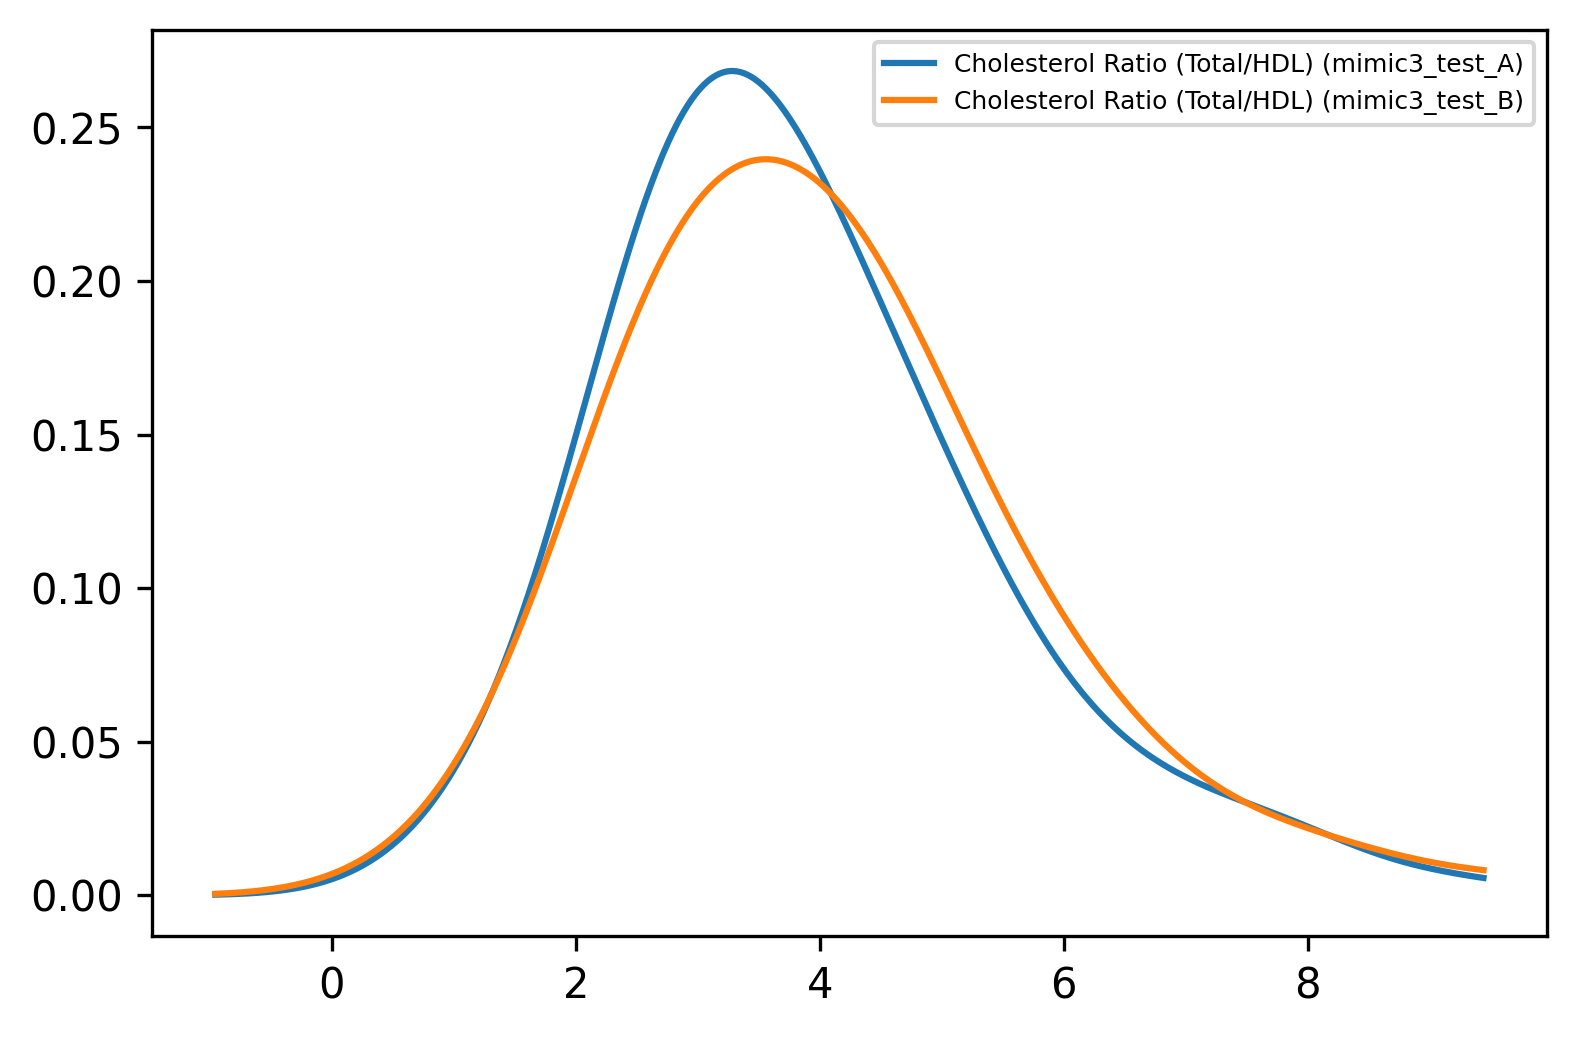

mimic3_test_A
entityid                         50954
label       Lactate Dehydrogenase (LD)
fluid                            Blood
category                     Chemistry
loinc                           2532-0
Name: 69, dtype: object

mimic3_test_B
entityid                         50954
label       Lactate Dehydrogenase (LD)
fluid                            Blood
category                     Chemistry
loinc                           2532-0
Name: 69, dtype: object
HD: 0.09032365528546683
KS: 0.059


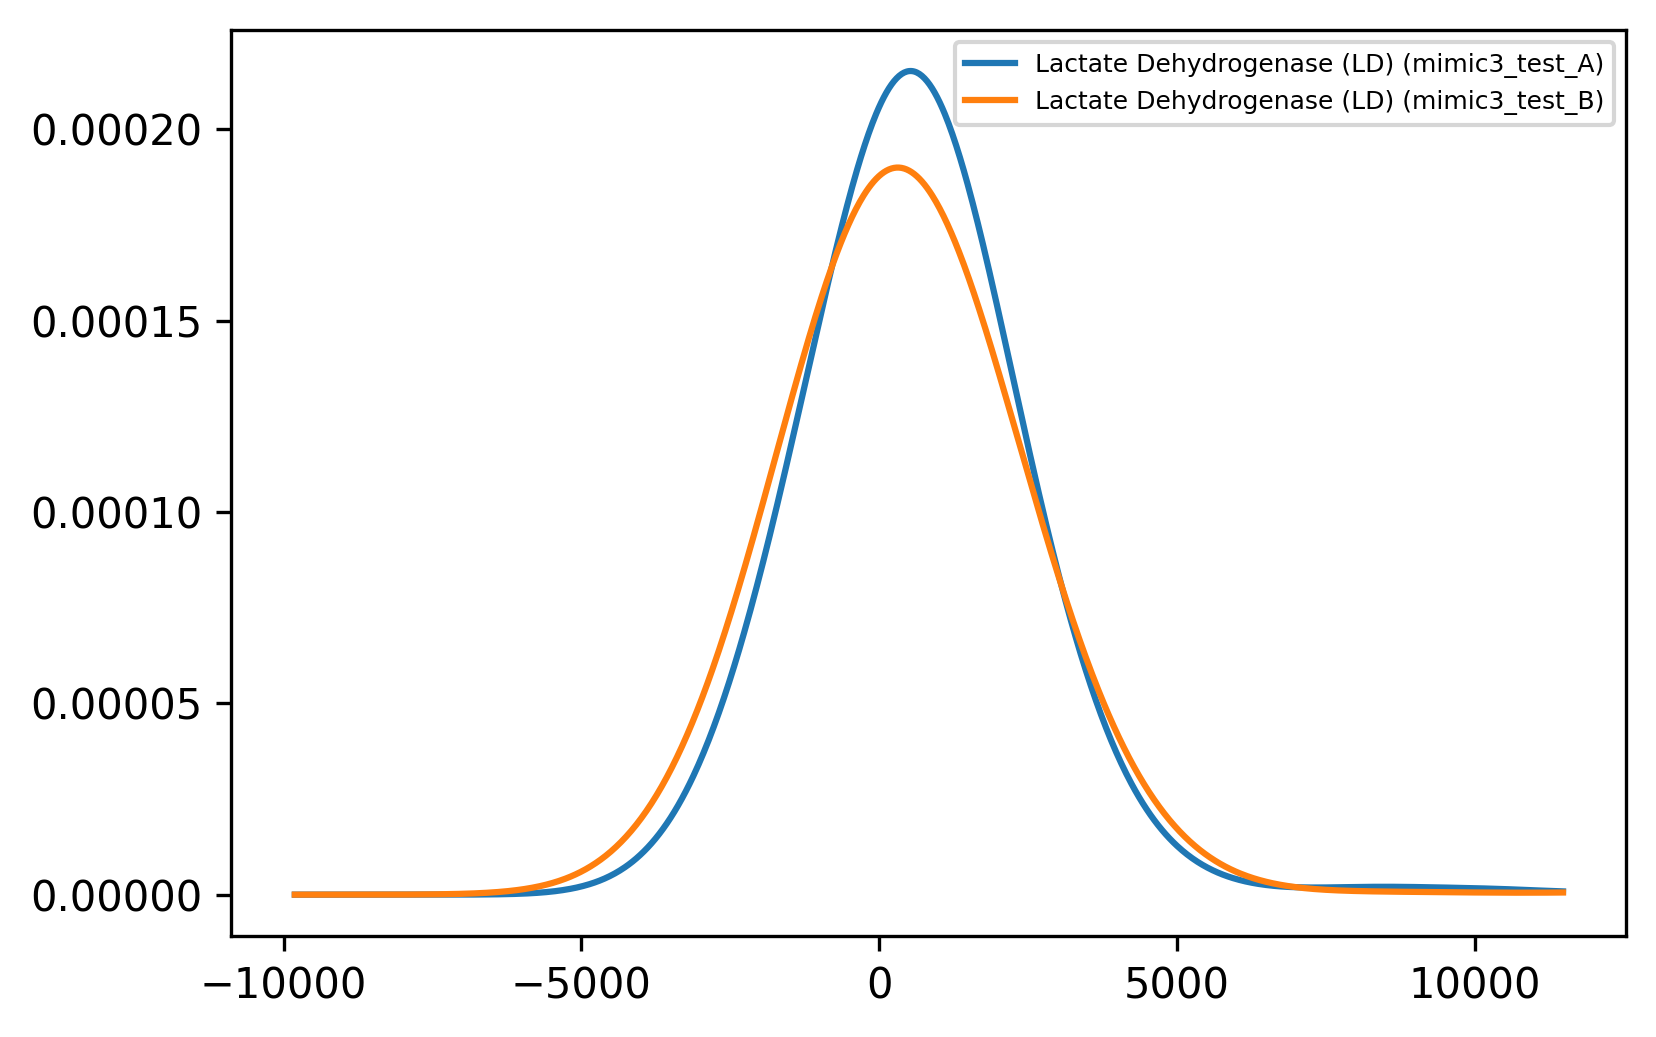

In [13]:
from dmatch.utils import Accessor
import matplotlib.pyplot as plt


for e1, e2 in [
    (f'50903:{INDEX_DIR}/mimic3_test_A', f'50903:{INDEX_DIR}/mimic3_test_B'),
    (f'50954:{INDEX_DIR}/mimic3_test_A', f'50954:{INDEX_DIR}/mimic3_test_B'),
]:
    print('mimic3_test_A')
    print(Accessor.get_entity_metadata(e1))
    print()
    print('mimic3_test_B')
    print(Accessor.get_entity_metadata(e2))

    k1 = Accessor.get_entity_kde(e1)
    k2 = Accessor.get_entity_kde(e2)

    e1x = Accessor.get_entity_data(e1)
    e2x = Accessor.get_entity_data(e2)
    x0 = min([e1x.mean() - 2 * e1x.std(), e2x.mean() - 2 * e2x.std()])
    x1 = max([e1x.mean() + 2 * e1x.std(), e2x.mean() + 2 * e2x.std()])
    x = np.linspace(x0, x1, 1000)
    
    print('HD:', Accessor.hellinger_distance_2entity(e1, e2))
    print('KS:', Accessor.ks_test_2entity(e1, e2)[0])

    plt.figure(dpi=300)
    plt.plot(x, k1(x), label=Accessor.get_entity_metadata(e1).label + " (mimic3_test_A)")
    plt.plot(x, k2(x), label=Accessor.get_entity_metadata(e2).label + " (mimic3_test_B)")
    plt.legend(loc='upper right', fontsize=6)
    plt.show()
